<a href="https://colab.research.google.com/github/hyeonji826/AI/blob/main/AI%20Agent/3_LangGraph_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 그래프의 상태 업데이트
- HumanMessage : 사용자(사람)의 메시지
- AIMessage : AI(LLM)의 메시지
- AnyMessage : HumanMessage, AIMessage를 포함하는 메시지

In [1]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 738.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 8.3 MB/s eta 0:00:00


In [9]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph
from langchain_core.messages import HumanMessage

In [3]:
class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

In [6]:
def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("안녕하세요! 무엇을 도와드릴까요?")

    return {"messages": new_message, "extra_field": 10}
    # return {"messages": messages + [new_message], "extra_field": 10}

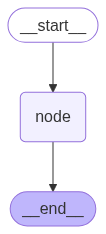

In [8]:
graph_builder = StateGraph(State)
graph_builder.add_node("node", node)
# set_entry_point : 그래프의 시작 노드를 지정하는 엣지 (START -> "node")
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

graph

In [12]:
result = graph.invoke({"messages": [HumanMessage("안녕")]})
# 워크플로우가 끝날때까지 기다려
result

{'messages': AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}),
 'extra_field': 10}

In [11]:
result["messages"]

AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={})

## 2. 대화메시지 상태 누적 업데이트
[add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) 는 기존 메시지에서 추가 메시지를 병합하는 데 사용하는 함수로, 새로 들어온 메시지를 추가할 때 사용할 수 있는 리듀서 역할

In [16]:
from typing_extensions import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph

In [14]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int

In [15]:
def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("안녕하세요! 무엇을 도와드릴까요?")

    return {"messages": new_message, "extra_field": 10}

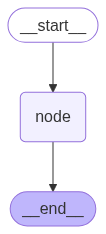

In [17]:
graph_builder = StateGraph(State)
graph_builder.add_node("node", node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

graph

In [18]:
input_message = {"role": "user", "content": "안녕하세요."}

result = graph.invoke({"messages": [input_message]})

for message in result["messages"]:
# pretty_print()는 데이터나 객체를 보기 좋게(Pretty) 정리해서 출력하는 함수
    message.pretty_print()

================================ Human Message =================================

안녕하세요.
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


In [19]:
result["messages"]

[HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='8fa15d41-a075-4e19-9121-f8f02a9f6f1d'),
 AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='0ee70963-e37a-40f3-9dfd-111e9bbd0cb6')]

In [20]:
# invoke : 하나의 요청에 대한 결과를 받을 때 까지 코드 실행 멈춤. 한번에 하나의 요청을 처리함
graph.invoke({"messages": [input_message]})

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='e506cd72-f67a-4ebc-a949-d1a2268b189f'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='ac47ab76-3b9d-47fa-aa5b-421ba44ea575')],
 'extra_field': 10}

In [21]:
# ainvoke : 비동기 처리로 여러 요청을 동시에 보낼 수 있음
await graph.ainvoke({"messages": [input_message]})

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='fd626327-7756-4bf9-bd3f-9dedbe5c10fb'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='47aede3d-7527-4d5c-b102-084a91c2c9c0')],
 'extra_field': 10}

In [26]:
# stream : 중간 결과를 실시간으로 반환함
# stream_mode="values" 각 단계의 현재 상태 값 출력

for chunk in graph.stream({"messages": [input_message]}, stream_mode="values"):
    print(chunk)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()  # 최근걸로 가져오기 위해서

{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='de6e206b-e1b5-48ad-a361-f7eccc1073eb')]}
================================ Human Message =================================

안녕하세요.
{'messages': [HumanMessage(content='안녕하세요.', additional_kwargs={}, response_metadata={}, id='de6e206b-e1b5-48ad-a361-f7eccc1073eb'), AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='331ea6fd-6e99-47b2-a81e-a81567687b46')], 'extra_field': 10}
================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


In [28]:
# Default) stream_mode="updates" 각 단계의 상태 업데이트만 출력

for chunk in graph.stream({"messages": [input_message]}, stream_mode="updates"):
    print(chunk)
    for node, value in chunk.items():
        if node:
            print(node)
        if "messages" in value:
            print(value['messages'].content)

{'node': {'messages': AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, id='be600756-6370-4150-8998-d950f893dbd9'), 'extra_field': 10}}
node
안녕하세요! 무엇을 도와드릴까요?


In [29]:
# stream_mode="messages" 각 단계의 메시지 출력

for chunk_msg, metadata in graph.stream({"messages": [input_message]}, stream_mode="messages"):
    print(chunk_msg)
    print(chunk_msg.content)
    print(metadata)
    print(metadata["langgraph_node"])

content='안녕하세요! 무엇을 도와드릴까요?' additional_kwargs={} response_metadata={} id='d4e4b2fd-c7bb-4fb6-a2d6-901a2265c911'
안녕하세요! 무엇을 도와드릴까요?
{'langgraph_step': 1, 'langgraph_node': 'node', 'langgraph_triggers': ('branch:to:node',), 'langgraph_path': ('__pregel_pull', 'node'), 'langgraph_checkpoint_ns': 'node:34a46aeb-bea0-34c6-9191-ef729e23c837'}
node


In [30]:
# astream : 비동기 방식으로 스트리밍 처리

async for chunk_msg, metadata in graph.astream({"messages": [input_message]}, stream_mode="messages"):
    print(chunk_msg)
    print(chunk_msg.content)
    print(metadata)
    print(metadata["langgraph_node"])

content='안녕하세요! 무엇을 도와드릴까요?' additional_kwargs={} response_metadata={} id='334b4ab2-f849-4014-b6dc-572dad94d26f'
안녕하세요! 무엇을 도와드릴까요?
{'langgraph_step': 1, 'langgraph_node': 'node', 'langgraph_triggers': ('branch:to:node',), 'langgraph_path': ('__pregel_pull', 'node'), 'langgraph_checkpoint_ns': 'node:0c6ade86-e150-9a90-6bb6-7b9269d5f24c'}
node


## 3. 노드와 엣지 연결

In [35]:
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph

In [34]:
class State(TypedDict):
    value_1: str
    value_2: int

In [32]:
def step_1(state: State):
    return {"value_1": state["value_1"]}

def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}

def step_3(state: State):
    return {"value_2": 10}

In [36]:
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

# 엣지 추가
graph_builder.add_edge(START, "step_1") # START ->1
graph_builder.add_edge("step_1", "step_2") # 1-> 2
graph_builder.add_edge("step_2", "step_3") # 2->3

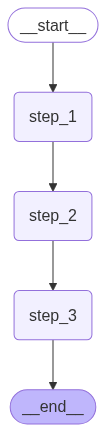

In [37]:
graph = graph_builder.compile()
graph

In [38]:
graph.invoke({"value_1": "apple"})

{'value_1': 'apple b', 'value_2': 10}

## 4. 노드와 엣지를 한번에 연결

In [39]:
graph_builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
graph_builder.add_edge(START, "step_1")

graph = graph_builder.compile()

graph.invoke({"value_1": "c"})

{'value_1': 'c b', 'value_2': 10}

## 5. 병렬로 연결

<img src="https://blog.kakaocdn.net/dna/b5Z9DU/btsQpGjiIsy/AAAAAAAAAAAAAAAAAAAAAMMy-AUOusPJobcd8x35j4V3INTB6kNWu51Ofb4poD0q/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=W1vEfrFY2g1UhiUyXaOF9S5%2F95A%3D" >

In [40]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

In [46]:
class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    # 업데이트 값이 뒤에 추가되도록 하는 operator.add 리듀서

In [42]:
def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

In [52]:
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)

# # 엣지 추가
# graph_builder.add_edge(START, "a")
# graph_builder.add_edge("a", "b") # a -> b
# graph_builder.add_edge("b", "c") # a -> c
# graph_builder.add_edge("c", "d") # b -> d
# graph_builder.add_edge("d", END)
# graph = graph_builder.compile()

# graph

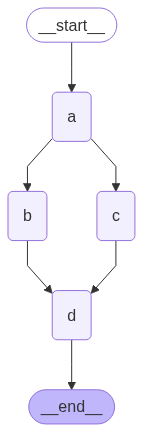

In [53]:
# 엣지 추가
graph_builder.add_edge(START, "a")
graph_builder.add_edge("a", "b") # a -> b
graph_builder.add_edge("a", "c") # a -> c
graph_builder.add_edge("b", "d") # b -> d
graph_builder.add_edge("c", "d") # c -> d
graph_builder.add_edge("d", END)
graph = graph_builder.compile()

graph

In [54]:
graph.invoke({"aggregate":[]})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

## 6. 조건부 엣지 병렬 연결

<img src ="https://blog.kakaocdn.net/dna/Nl3ls/btsQnPobZYW/AAAAAAAAAAAAAAAAAAAAAHrWFa9bu2RqRVxUhVtf5umCwt3sNieiRIQrPFvGeRdh/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=rhOuU%2BRKv%2FSgvD%2F2YOxkrW697t4%3D">

In [55]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

In [56]:
class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    which: str

In [57]:
def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}

In [58]:
graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)
graph_builder.add_node(e)
graph_builder.add_edge(START, "a")

In [59]:
# bc 혹은 cd 로 라우트를 결정하는 함수
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]   # 노드 이름

intermediates = ["b", "c", "d"]
graph_builder.add_conditional_edges(
    # 조건을 주는 add_conditional
    "a",
    route_bc_or_cd, # 콜백
    intermediates,  # 적용
)

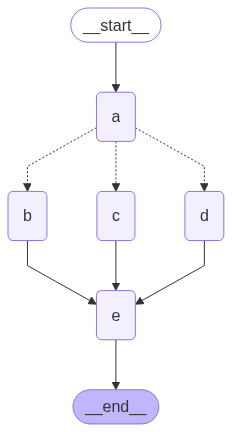

In [60]:
for node in intermediates:
    graph_builder.add_edge(node, "e")

graph_builder.add_edge("e", END)
graph = graph_builder.compile()
graph

In [61]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "E" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'E'], 'which': 'bc'}

In [62]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding "A" to []
Adding "C" to ['A']
Adding "D" to ['A']
Adding "E" to ['A', 'C', 'D']


{'aggregate': ['A', 'C', 'D', 'E'], 'which': 'cd'}

## 7. 조건과 반복

<img src="https://blog.kakaocdn.net/dna/Dzd0z/btsQrpucyz3/AAAAAAAAAAAAAAAAAAAAAKgOB0lqhrzSxOTe8JTdthzi16_ieiISYCRZSDjfb7E9/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=hdCsI5%2FFi0FO91mTCv6zqLzYd7w%3D">

In [95]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

In [96]:
class State(TypedDict):
    aggregate: Annotated[list, operator.add]

In [97]:
def a(state: State):
    print(f'Node A 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["B"]}


graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)

In [98]:
def route(state: State):
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


graph_builder.add_edge(START, "a")
graph_builder.add_conditional_edges("a",list[b])
graph_builder.add_edge("b", "a")
graph = graph_builder.compile()

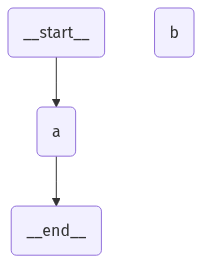

In [99]:
import requests, zlib, base64
from IPython.display import Image

# Mermaid 코드 추출
code = graph.get_graph().draw_mermaid()

# 압축·인코딩 후 Kroki 요청
encoded = base64.urlsafe_b64encode(zlib.compress(code.encode())).decode()
url = f"https://kroki.io/mermaid/png/{encoded}"
resp = requests.get(url)
display(Image(resp.content))

In [100]:
graph.invoke({"aggregate": []})

Node A 처리 중 현재 상태값 : []


{'aggregate': ['A']}

In [101]:
from langgraph.errors import GraphRecursionError
# GraphRecursionError 로 에러를 반환하는 방법
try:
    graph.invoke({"aggregate": []}, config={"recursion_limit": 4})
except GraphRecursionError: # 반복 종료 조건에 도달할 수 없는 경우
    print("Recursion Error")

Node A 처리 중 현재 상태값 : []


## 8. 조건에 따른 반복 처리하기

<img src="https://blog.kakaocdn.net/dna/7YUWL/btsQocQUV85/AAAAAAAAAAAAAAAAAAAAAMhiJftB0gvNd2P3K4wDKjhLXJ8hLH2OLoqitKa-SA-F/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=H7u2m6ggAVjbzB3a9JDv%2FhB%2BEgc%3D">

In [102]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

In [103]:
class State(TypedDict):
    aggregate: Annotated[list, operator.add]

In [104]:
def a(state: State):
    print(f'Node A 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Node B 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Node C 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Node D 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["D"]}

graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)

In [105]:
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


graph_builder.add_edge(START, "a")
graph_builder.add_conditional_edges("a", route)
graph_builder.add_edge("b", "c")
graph_builder.add_edge("b", "d")
graph_builder.add_edge(["c", "d"], "a")
graph = graph_builder.compile()

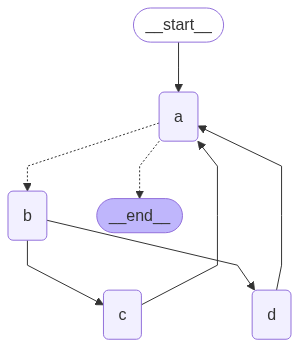

In [110]:
graph

In [106]:
result = graph.invoke({"aggregate": []})

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node C 처리 중 현재 상태값 : ['A', 'B']
Node D 처리 중 현재 상태값 : ['A', 'B']
Node A 처리 중 현재 상태값 : ['A', 'B', 'C', 'D']
Node B 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A']
Node C 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B']
Node D 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B']
Node A 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


## 9. 사용자 입력에 따른 반복 조건 설정

<img src="https://blog.kakaocdn.net/dna/zdVkz/btsQoKT48zQ/AAAAAAAAAAAAAAAAAAAAAC65qmXT5E6KWmmgOPo6AscG8W4uY_sa-b2cEln86K6g/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=j%2BgbkY9VP3JL7D5l8CqN5qwf%2F70%3D">

In [107]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages

In [111]:
class State(TypedDict):
    human_messages: Annotated[list[HumanMessage], add_messages]
    ai_messages: Annotated[list[AIMessage], add_messages]
    retry_num : int

In [112]:
def chatbot(state:State):
    retry_num = state["retry_num"]
    user_input = input(f"(현재 {retry_num}번째 답변) 사용자 입력: ")
    ai_message = AIMessage(f"{retry_num}번째 답변중!")

    return {"human_messages": [HumanMessage(content=user_input)], "ai_messages": [ai_message]}

def retry(state: State):
    return {"retry_num" : state["retry_num"] + 1}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("retry", retry)

In [113]:
def route(state: State):
    if "반복" in state["human_messages"][-1].content:
        return "retry"
    else:
        return END


graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", route)
graph_builder.add_edge("retry", "chatbot")
graph = graph_builder.compile()

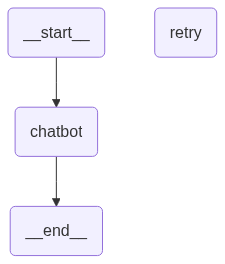

In [117]:
graph

In [118]:
for chunk in graph.stream({"human_messages" : "반복", "retry_num": 0}, stream_mode="updates"):
    print(chunk)
    for node, value in chunk.items():
        if node:
            print(node)
        if "messages" in value:
            print(value['messages'].content)

(현재 0번째 답변) 사용자 입력: 반복
{'chatbot': {'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='7f7686b4-efde-4a1e-b4cc-b76c54aed5bc')], 'ai_messages': [AIMessage(content='0번째 답변중!', additional_kwargs={}, response_metadata={}, id='05e0815b-fc64-4fe8-be9f-cf4b3ae8ba4c')]}}
chatbot
{'retry': {'retry_num': 1}}
retry
(현재 1번째 답변) 사용자 입력: 반복
{'chatbot': {'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='919fe998-ba9b-4eb5-8c28-299851bc327d')], 'ai_messages': [AIMessage(content='1번째 답변중!', additional_kwargs={}, response_metadata={}, id='e0ca6d27-1aa8-481a-b3d6-8b900f1b62d5')]}}
chatbot
{'retry': {'retry_num': 2}}
retry
(현재 2번째 답변) 사용자 입력: 반복
{'chatbot': {'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='008b0a13-999e-43dd-9dca-f86da43ad6df')], 'ai_messages': [AIMessage(content='2번째 답변중!', additional_kwargs={}, response_metadata={}, id='2f104311-fcf7-42ba-8c1b-5c61d793316d'

In [119]:
graph.invoke({"human_messages" : "반복", "retry_num": 0})

(현재 0번째 답변) 사용자 입력: 반복
(현재 1번째 답변) 사용자 입력: 반복
(현재 2번째 답변) 사용자 입력: 반복
(현재 3번째 답변) 사용자 입력: 메롱


{'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='71b81b1a-f972-4d8d-8270-9b77a504a731'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='177e6af4-dcf9-4b72-9f97-b3e7cc08ad05'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='4ae0b673-41e3-42b4-afd3-bda0a3db8967'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='f2581739-575e-4d6b-82da-4ccc5233053e'),
  HumanMessage(content='메롱', additional_kwargs={}, response_metadata={}, id='28ad5080-dabe-4261-8b86-d992f428186e')],
 'ai_messages': [AIMessage(content='0번째 답변중!', additional_kwargs={}, response_metadata={}, id='2238a659-2502-44d0-b614-7e4342afebea'),
  AIMessage(content='1번째 답변중!', additional_kwargs={}, response_metadata={}, id='2393c730-4de4-4fcb-a295-b2b432423a0c'),
  AIMessage(content='2번째 답변중!', additional_kwargs={}, response_metadata={}, id='8e4f5b7f-3e5c-421f-9391-44e87c2af6f8'),
  AIMessage(content='